In [1]:
import numpy as np
import cupy as cp
import sys
import pandas as pd
import time
import matplotlib.pyplot as plt
import h5py
from types import SimpleNamespace
import warnings
warnings.filterwarnings("ignore", message=f".*peer.*")


sys.path.insert(0, '..')
from utils import *
from rec import Rec

# Init data sizes and parametes of the PXM of ID16A

In [2]:
ids = np.concatenate((np.arange(2200),np.arange(3000,7200)))

In [3]:
with h5py.File(f'/data/vnikitin/ESRF/ID16A/20240924_h5/Chip/Chip_codedht_random2_010nm/data.h5') as fid:
    sx0 = fid['/exchange/sx0'][0]    
    detector_pixelsize = fid['/exchange/detector_pixelsize'][0]    
    focusToDetectorDistance = fid['/exchange/focusdetectordistance'][0]    
    z10 = fid['/exchange/z1'][0]    
    theta = fid['/exchange/theta'][ids]
    shifts = fid['/exchange/shifts'][ids]
    attrs = fid['/exchange/attrs'][ids]
    pos_shifts = fid['/exchange/pos_shifts'][ids]*1e-6
    pos_shifts-=pos_shifts[0]

In [4]:
# with h5py.File(f'/data/vnikitin/ESRF/ID16A/20240924_h5/Chip/Chip_codedht_random2_010nm/data_corrected.h5','a') as fid:
#     fid['/exchange/theta'][:] = theta

In [5]:
z1c = -17.75e-3
energy = 33.35  # [keV] xray energy
wavelength = 1.2398419840550367e-09/energy  # [m] wave length
z1 = z10 - sx0
z2 = focusToDetectorDistance-z1
distance = (z1*z2)/focusToDetectorDistance
magnifications = focusToDetectorDistance/z1
voxelsize = np.abs(detector_pixelsize/magnifications)
magnifications2 = z1/z1c
distancec = (z1-z1c)/(z1c/z1)#magnifications2

show = True
print(distance,distancec)

0.0042001265 -0.0052144392


In [6]:
pos_shifts/=voxelsize
pos_shifts[:,1]*=-1

In [7]:
theta_step = 1
theta = theta[::theta_step]
attrs = attrs[::theta_step]
shifts = shifts[::theta_step]
pos_shifts = pos_shifts[::theta_step]
ntheta = len(theta)

## Read data

In [8]:

with h5py.File(f'/data/vnikitin/ESRF/ID16A/20240924_h5/Chip/Chip_codedht_random2_010nm/data.h5') as fid:
    data = fid['/exchange/data'][ids][::theta_step].astype('float32')
    ref0 = fid['/exchange/data_white0'][:].astype('float32')
    ref1 = fid['/exchange/data_white1'][:].astype('float32')
    dark = fid['/exchange/data_dark'][:].astype('float32')


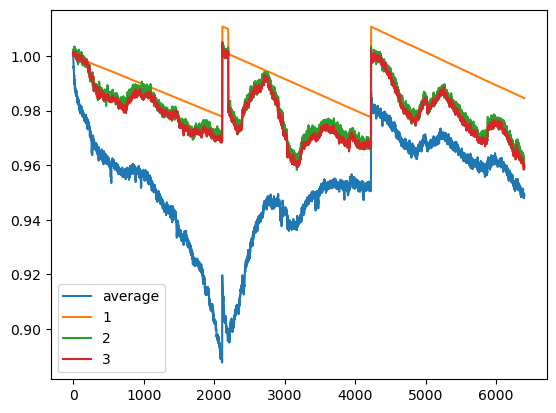

In [9]:
mm = np.mean(data,axis=(1,2))


plt.plot(mm/mm[0],label='average')
plt.plot(attrs[:,0]/attrs[0,0],label='1')
plt.plot(attrs[:,1]/attrs[0,1],label='2')
plt.plot(attrs[:,2]/attrs[0,2],label='3')
plt.legend()


# Pre-processing

26
30
29
34
33
31
25
24
26
24
23
21
28
27
30
23
27
18
29
19
32
24
28
25
24
19
15
22
22
33
27
30
16
20
26
26
20
22
21
16
21
25
20
20
22
22
26
22
28
22
14
26
29
24
16
36
17
18
29
26
33
20
21
21
21
25
23
22
29
28
29
25
19
20
22
29
26
17
20
23
17
29
28
26
28
18
26
23
14
24
22
19
16
25
21
24
23
32
15
23
19
20
19
18
22
15
19
19
32
24
24
20
22
27
21
22
27
21
25
24
18
18
18
26
27
14
23
19
30
21
26
26
20
21
23
25
23
24
20
21
25
19
22
22
25
21
25
22
18
25
17
22
25
19
21
29
15
20
16
20
16
23
14
20
17
20
22
21
24
12
13
20
19
19
15
21
19
18
19
20
24
28
21
18
20
31
27
22
17
29
19
23
22
17
12
18
23
25
12
28
18
16
26
14
20
17
22
24
25
17
24
26
21
21
16
19
15
15
22
23
29
31
24
20
14
15
21
26
19
14
25
13
19
15
15
24
20
20
17
20
21
20
11
17
28
23
19
22
19
18
21
15
23
24
14
25
16
13
21
20
23
28
27
21
27
23
29
21
24
23
14
30
21
16
28
19
19
23
21
17
24
9
12
13
22
19
18
12
26
14
20
15
21
13
20
19
21
25
24
19
10
25
23
23
18
25
18
23
23
20
19
20
23
16
16
22
16
15
21
20
22
28
15
20
28
18
24
15
24
22
18
21
17
19

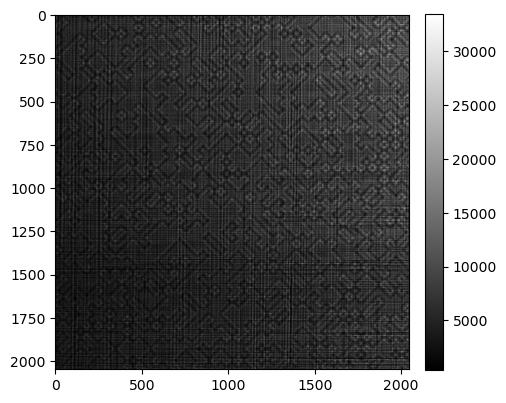

In [10]:
import cupyx.scipy.ndimage as ndimage
def remove_outliers(data, dezinger, dezinger_threshold):    
    res = data.copy()
    w = [dezinger,dezinger]
    for k in range(data.shape[0]):
        data0 = cp.array(data[k])
        fdata = ndimage.median_filter(data0, w)
        print(np.sum(np.abs(data0-fdata)>fdata*dezinger_threshold))
        res[k] = np.where(np.abs(data0-fdata)>fdata*dezinger_threshold, fdata, data0).get()
    return res

dark = np.mean(dark,axis=0)
data -= dark
ref0-=dark
ref1-=dark

data[data<0]=0
ref0[ref0<0] = 0
ref1[ref1<0] = 0
data[:,1320//3:1320//3+25//3,890//3:890//3+25//3] = data[:,1280//3:1280//3+25//3,890//3:890//3+25//3]
ref0[:,1320//3:1320//3+25//3,890//3:890//3+25//3] = ref0[:,1280//3:1280//3+25//3,890//3:890//3+25//3]
ref1[:,1320//3:1320//3+25//3,890//3:890//3+25//3] = ref1[:,1280//3:1280//3+25//3,890//3:890//3+25//3]

data = remove_outliers(data, 3, 0.8)    
ref0 = remove_outliers(ref0, 3, 0.8)    
ref1 = remove_outliers(ref1, 3, 0.8)    

mshow(data[0],mshow)

In [11]:
ref0=np.mean(ref0,axis=0)
cnorm = np.mean(ref0)
data=data/cnorm/(attrs[:,1]/attrs[0,1])[:,np.newaxis,np.newaxis]
ref0/=cnorm


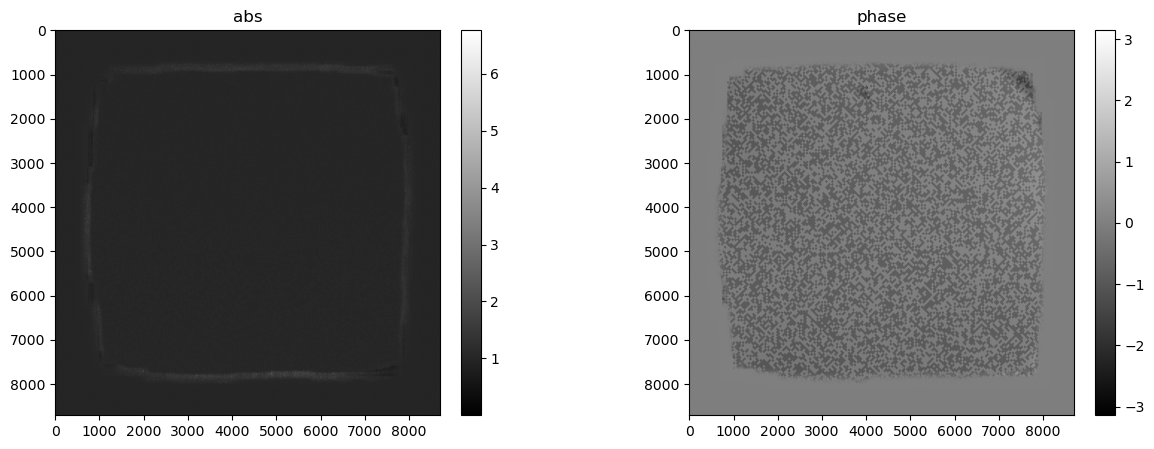

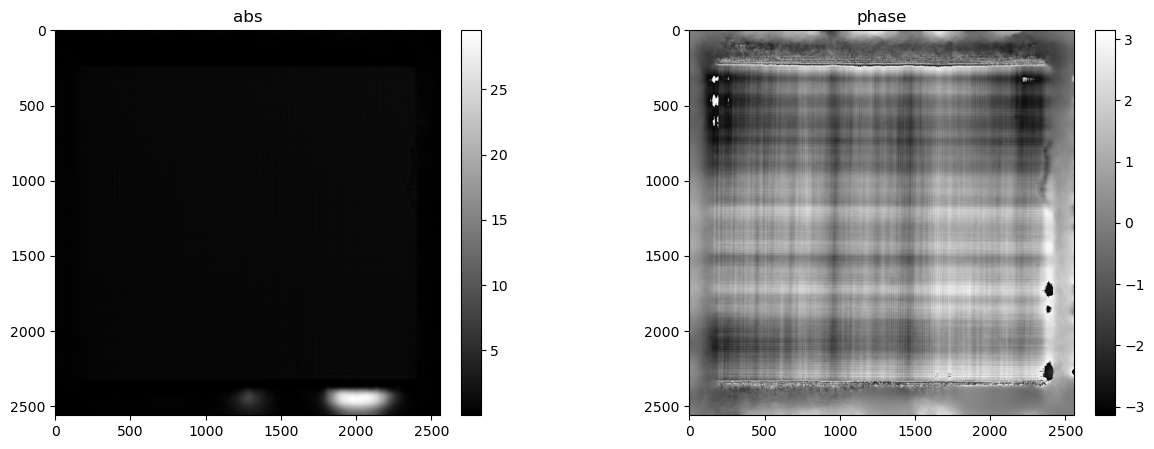

In [12]:
iter=8192
path_code = '/data/vnikitin/ESRF/ID16A/20240924_rec0224/SiemensLH/code2um_nfp18x18_01/bets_final_256_0.05_2/'
code_angle = read_tiff(f'{path_code}/rec_psi_angle/{iter:04}.tiff')
code_abs = read_tiff(f'{path_code}/rec_psi_abs/{iter:04}.tiff')
code = code_abs*np.exp(1j*code_angle)
mshow_polar(code,show)

q_angle = read_tiff(f'{path_code}/rec_prb_angle/{iter:04}.tiff')
q_abs = read_tiff(f'{path_code}/rec_prb_abs/{iter:04}.tiff')
q = q_abs*np.exp(1j*q_angle)
mshow_polar(q,show)

In [13]:
args = SimpleNamespace()

args.ngpus = 1#int(sys.args[1])
args.n = 8704
args.ncode = 8704
args.npsi = 8704
args.pad = 0
args.nq = 8704
args.ex = 0
args.npatch = 8704
args.npos = 1
args.nchunk = 1
args.ntheta=1
args.theta=np.array([0])
args.rotation_axis=0

args.voxelsize = voxelsize
args.wavelength = wavelength
args.distance = distance
args.distancec = distancec

# doesnt matter
args.lam = 0
args.eps = 1e-8
args.rho = [1, 0.01, 0.1]
args.crop = 0
args.path_out = ""
args.niter = 2049
args.err_step = 1
args.vis_step = 8
args.method = "BH-CG"

args.show = True

# create class
cl_rec = Rec(args)

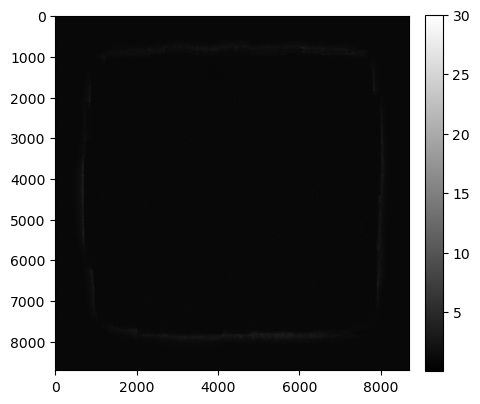

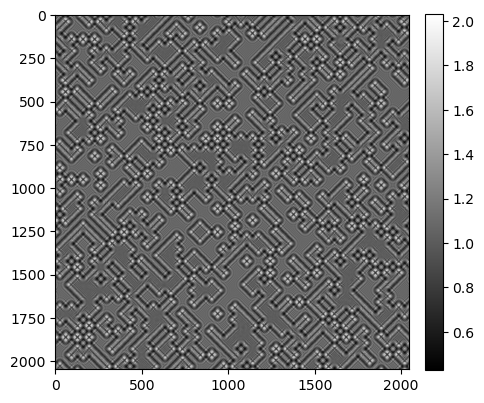

In [14]:
code =cp.array(code)
cdata = np.abs(cl_rec.D(cl_rec.Dc(code[np.newaxis]))[0])**2
mshow(cdata,show)
mshow(cdata[2000:4048,2000:4048],show)

In [15]:
args.ngpus = 4
args.n = 2048
args.pad = args.n // 8
args.npsi = args.n + 2 * args.pad
args.nq = args.n + 2 * args.pad
args.ex = 8
args.npatch = args.nq + 2 * args.ex
args.nchunk = 4
args.ntheta = len(theta)
args.theta = theta
cl_rec = Rec(args)

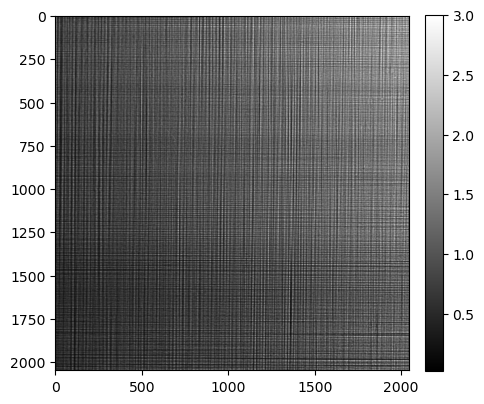

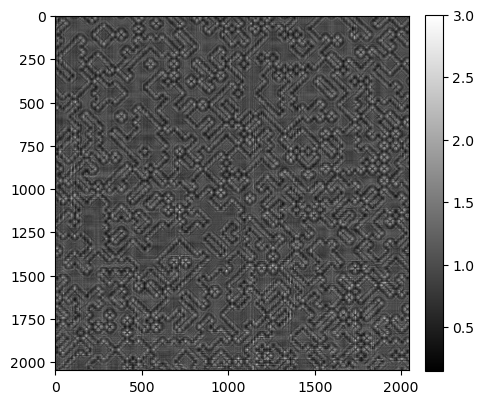

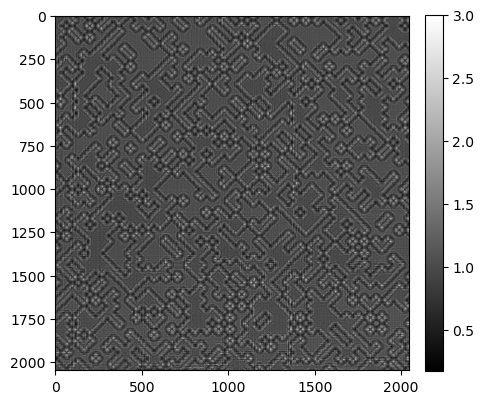

In [16]:
ref = np.abs(cl_rec.D(cl_rec.Dc(q[np.newaxis]))[0])**2
rdata = data/(ref+1e-6)
rref0 = ref0/(ref+1e-6)
mshow(ref,show,vmax=3)
mshow(rdata[0],show,vmax=3)
mshow(rref0,show,vmax=3)

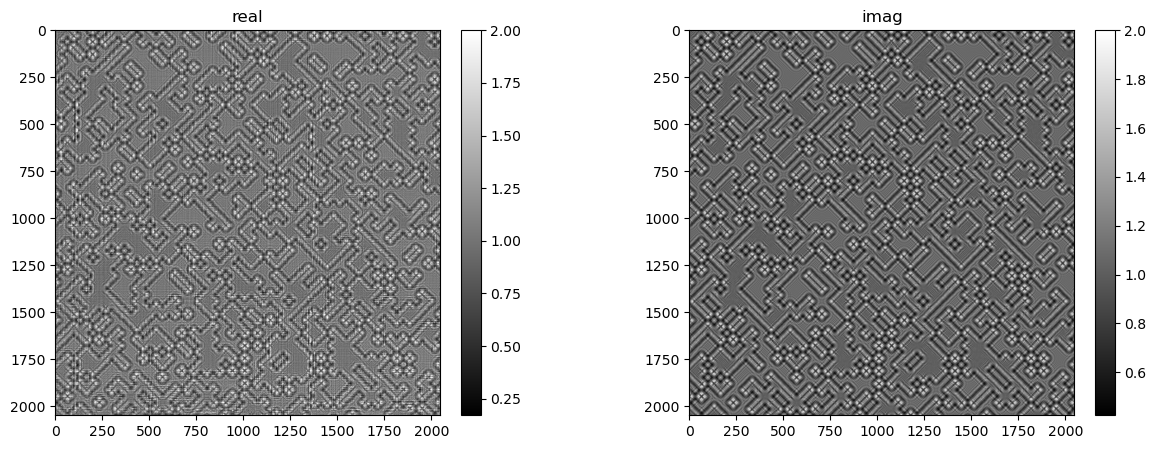

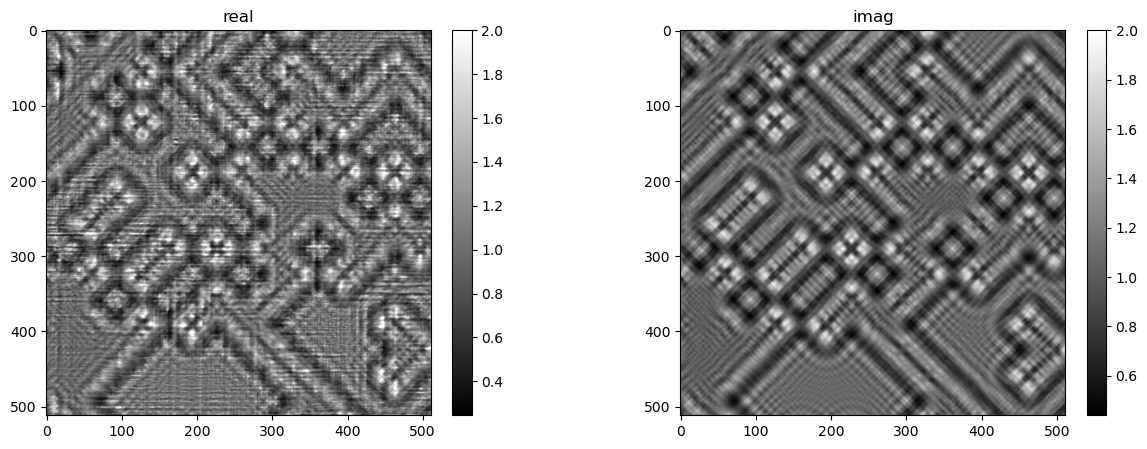

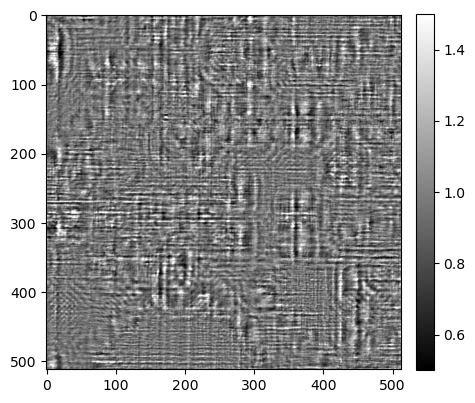

[1110. -117.]


In [17]:
def my_phase_corr(d1, d2):
    image_product = np.fft.fft2(d1) * np.fft.fft2(d2).conj()
    cc_image = np.fft.fftshift(np.fft.ifft2(image_product))
    ind = np.unravel_index(np.argmax(cc_image.real, axis=None), cc_image.real.shape)
    shifts = cp.zeros(2,'float32')
    shifts[0] = ind[0]
    shifts[1] = ind[1]
    shifts -= d1.shape[-1]//2
    return shifts.get()

shifts_code_ref = np.zeros([args.ntheta,2],dtype='float32')
a = cp.array(cdata)
nn = cdata.shape[-1]
rrref0=rref0.copy()
b = cp.pad(cp.array(rref0),((nn//2-args.n//2,nn//2-args.n//2),(nn//2-args.n//2,nn//2-args.n//2)),'constant',constant_values=1)
shifts_code_ref = -my_phase_corr(a,b)
aa = a[nn//2-shifts_code_ref[0]-args.n//2:nn//2-shifts_code_ref[0]+args.n//2,
        nn//2-shifts_code_ref[1]-args.n//2:nn//2-shifts_code_ref[1]+args.n//2]
bb = cp.array(rref0)
rrref0 = (bb/aa).get()
mshow_complex(bb+1j*aa,show,vmax=2)
mshow_complex(bb[512:1024,512:1024]+1j*aa[512:1024,512:1024],show,vmax=2)
mshow(rrref0[512:1024,512:1024],show,vmin=0.5,vmax=1.5)
print(shifts_code_ref)
np.save('shifts_code_ref',shifts_code_ref)

# find shift with 1 pixel accuracy

[184. 772.]
[1167.  178.]
[ 864. -744.]
[ 762. -104.]
[237. 272.]
[129. 716.]
[ 708. 1303.]
[1122. 1112.]
[189. 377.]
[ 867. -426.]
[-785. 1390.]
[460. 806.]
[-1000.  1208.]
[1000. -796.]
[ 810. 1342.]
[951. 315.]
[-1216.   185.]
[-503. -310.]
[-512. 1063.]
[1119. 1323.]
[-1272.   821.]
[ 508. 1047.]
[956. 362.]
[-1049.  -421.]
[ 518. -774.]
[1118. 1049.]
[ 719. -317.]
[  -21. -1018.]
[-185. -814.]
[-244.  686.]
[955. 241.]
[-508.  -31.]
[1033.  583.]
[-403.  189.]
[-1164.   346.]
[-1048.  -832.]
[ 860. 1190.]
[ 194. -689.]
[-1107.  -284.]
[-676.  762.]
[-998.  494.]
[-671. -201.]
[ 558. 1328.]
[ 132. 1464.]
[-400.  499.]
[ 900. 1591.]
[ 82. 430.]
[ 191. -425.]
[-1054.   296.]
[1164.  927.]
[402. 326.]
[-995. -181.]
[-1056.   467.]
[1121. 1729.]
[-512. 1524.]
[ 824. -640.]
[-1165.   627.]
[1034. 1190.]
[-676. 1283.]
[-558. -862.]
[1131. -741.]
[1125. -115.]
[-946.  182.]
[-136. 1093.]
[ 916. -154.]
[-242. 1431.]
[ -126. -1139.]
[-782. -625.]
[-783. -158.]
[-948.  804.]
[-130. -763.]
[1

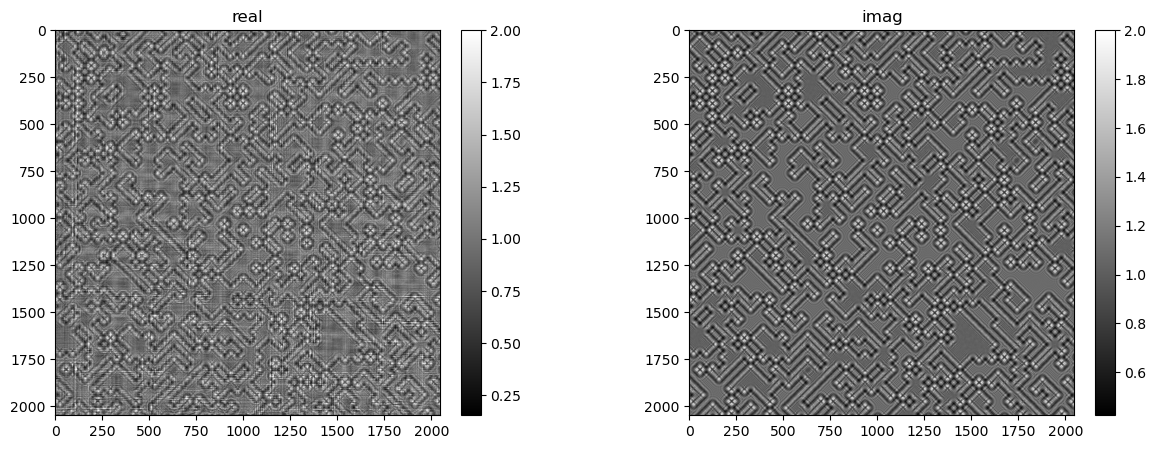

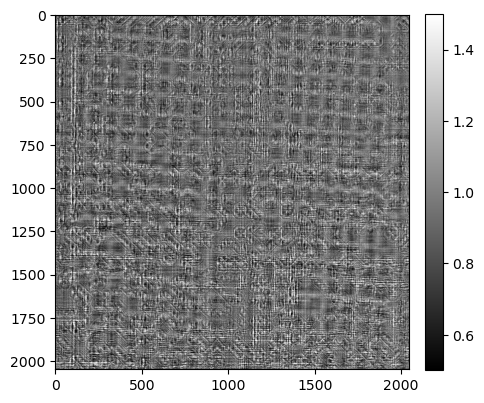

[[  184.   772.]
 [ 1167.   178.]
 [  864.  -744.]
 ...
 [ -477.    55.]
 [-1022.    67.]
 [ -313. -1003.]]


In [18]:
def my_phase_corr(d1, d2):
    image_product = np.fft.fft2(d1) * np.fft.fft2(d2).conj()
    cc_image = np.fft.fftshift(np.fft.ifft2(image_product))
    ind = np.unravel_index(np.argmax(cc_image.real, axis=None), cc_image.real.shape)
    shifts = cp.zeros(2,'float32')
    shifts[0] = ind[0]
    shifts[1] = ind[1]
    shifts -= d1.shape[-1]//2
    return shifts.get()

shifts_code = np.zeros([args.ntheta,2],dtype='float32')
a = cp.array(cdata)
nn = cdata.shape[-1]
rrdata=rdata.copy()
for k in range(rdata.shape[0]):        
    b = cp.pad(cp.array(rdata[k]),((nn//2-args.n//2,nn//2-args.n//2),(nn//2-args.n//2,nn//2-args.n//2)),'constant',constant_values=1)
    shift = -my_phase_corr(a,b)
    # mshow_complex(a+1j*b,show,vmax=2)
    shifts_code[k] = shift
    print(shift)
    try:
        aa = a[nn//2-shift[0]-args.n//2:nn//2-shift[0]+args.n//2,
            nn//2-shift[1]-args.n//2:nn//2-shift[1]+args.n//2]
        bb = cp.array(rdata[k])
        rrdata[k] = (bb/aa).get()
    except:
        print(k,'!!!!!!!!!!!!!!!!!!!!')
        pass
mshow_complex(bb+1j*aa,show,vmax=2)
mshow(rrdata[-1],show,vmin=0.5,vmax=1.5)
print(shifts_code)
np.save('shifts_code',shifts_code)

In [19]:
import dxchange
dxchange.write_tiff_stack(rrdata,'/data/tmp/rdata/r',overwrite=True)

astropy module not found
olefile module not found


In [20]:
shifts[:5]
shifts_cor = shifts[:,::-1].copy()
# v=np.arange(-ntheta//2,ntheta//2)/(ntheta//2)
# cc = 4*v**2
# cc[3*ntheta//4:]+=8*(v[3*ntheta//4:]-v[3*ntheta//4])
# cc[7*ntheta//8:]+=8*(v[7*ntheta//8:]-v[7*ntheta//8])
# shifts_cor[:,0]+=cc*7/10
# plt.plot(cc)

In [21]:
def S(psi, p):
    """Apply shift for all projections."""
    res=psi.copy()
    for k in range(p.shape[0]):
        psi0 = cp.array(psi[k:k+1])
        p0 = cp.array(p[k:k+1])
        tmp = cp.pad(psi0,((0,0),(args.n//2,args.n//2),(args.n//2,args.n//2)), 'symmetric')
        [x, y] = cp.meshgrid(cp.fft.rfftfreq(2*args.n),
                            cp.fft.fftfreq(2*args.n))
        shift = cp.exp(-2*cp.pi*1j *
                    (x*p0[:, 1, None, None]+y*p0[:, 0, None, None]))
        res0 = cp.fft.irfft2(shift*cp.fft.rfft2(tmp))
        res[k] = res0[:, args.n//2:3*args.n//2, args.n//2:3*args.n//2].get()
    return res

srrdata = S(rrdata,-shifts_cor)
dxchange.write_tiff_stack(srrdata,'/data/tmp/s2rdata/r',overwrite=True)

In [22]:
np.save('shifts_cor',shifts_cor)

In [23]:
ri = np.round(shifts_code).astype('int32')
r = shifts_code-ri
code=cp.array(code)
a = cl_rec.S(ri,r,code)*q
# print(np.linalg.norm(a))
b = cl_rec.Dc(a)
# print(np.linalg.norm(b))
cdata2 = np.abs(cl_rec.D(b))**2
# print(np.linalg.norm(cdata2))
# cdata2 = np.abs(cl_rec.D(cl_rec.Dc(cl_rec.S(ri,r,code)*q)))**2

1.0000053e-08


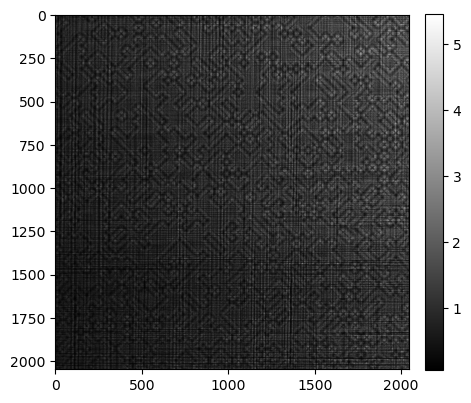

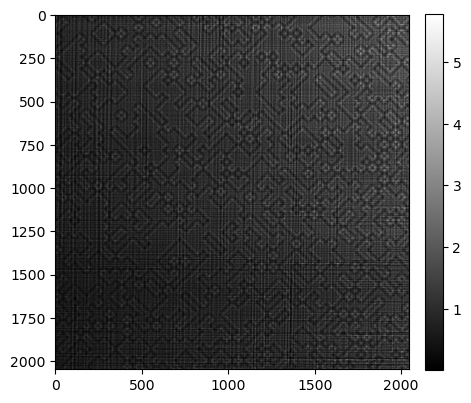

In [24]:
print(voxelsize)
mshow(data[0],show)
mshow(cdata2[0],show)

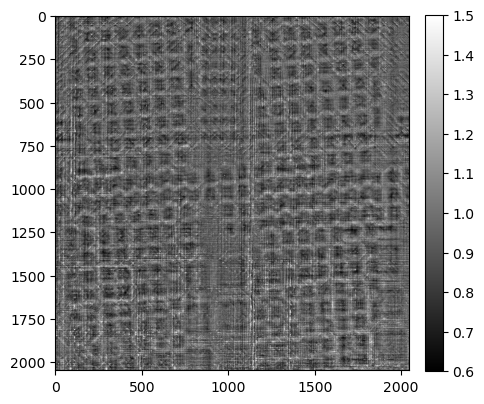

In [25]:
mshow(data[2]/cdata2[2],show,vmax=1.5,vmin=0.6)

In [26]:
cdata=cdata.get()

In [27]:
code=code.get()

In [28]:

path_out = '/data/vnikitin/ESRF/ID16A/20240924_h5/Chip/Chip_codedht_random2_010nm/'

with  h5py.File(f'{path_out}/data_corrected.h5','w') as fid:
    fid.create_dataset('/exchange/cdata2',data=cdata2)
    fid.create_dataset('/exchange/cdata',data=cdata)
    fid.create_dataset('/exchange/ref',data=ref)
    fid.create_dataset('/exchange/prb',data=q)
    fid.create_dataset('/exchange/code',data=code)
    fid.create_dataset('/exchange/shifts_cor',data=shifts_cor)
    fid.create_dataset('/exchange/shifts_code',data=shifts_code)
    dvoxelsize = fid.create_dataset('/exchange/voxelsize',shape=(1,),dtype='float32')
    dvoxelsize[0]=voxelsize
    dsx0 = fid.create_dataset('/exchange/sx0',shape=(1,),dtype='float32')
    dsx0[0] = sx0
    dz1 = fid.create_dataset('/exchange/z1',shape=(1,),dtype='float32')
    dz1[0]=z10
    ddetector_pixelsize = fid.create_dataset('/exchange/detector_pixelsize',shape=(1,),dtype='float32')
    ddetector_pixelsize[0]=detector_pixelsize
    dfocusdetectordistance = fid.create_dataset('/exchange/focusdetectordistance',shape=(1,),dtype='float32')
    dfocusdetectordistance[0]=focusToDetectorDistance
    fid.create_dataset('/exchange/data',data=data)
    fid.create_dataset('/exchange/ref0',data=ref0)
    fid.create_dataset('/exchange/ref1',data=ref1)
    fid.create_dataset('/exchange/theta',data=theta)


